# Install Libraries if Needed (Only Run Once)

In [ ]:
# !pip install -U deepxde

# Import Libraries

In [1]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re
import os

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Lorentz System
$$
x_t = C_1(y-x)\\
y_t = x(C_2-z) - y\\
z_t = x y - C_3 z\\
t\in[0,t_{end}],\\
$$
Defaults are $C_1 = 10$, $C_2 = 28$, $C_3=8/3$, and $t_{end}=3$.  This system is known to exhibit chaos for certain coeffient values.  See https://en.wikipedia.org/wiki/Lorenz_system for more details.

# Generate Training Data

In [3]:
def gen_training_data(C1=10.0, C2=28.0, C3=8.0/3.0, x0=5, y0=8, z0=2, tend=3, dt=0.01, tskip=1):
    # C1 = 10.0
    # C2 = 28.0
    # C3 = 8.0 / 3.0
    # x0 = 5
    # y0 = 8
    # z0 = 2
    # tend = 3

    def f(state, t):
        x, y, z = state  # Unpack the state vector
        return [C1 * (y - x),
                x * (C2 - z) - y, 
                x * y - C3 * z]  # Derivatives

    state0 = [x0, y0, z0]
    t = np.arange(0.0, tend, dt)
    states = odeint(f, state0, t)
    t = np.reshape(t,(-1,1))
    return t[::tskip], states[::tskip], state0, tend

def plot_states(t, states):
    # plt.close('all')s
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(states[:, 0], states[:, 1], states[:, 2])
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    

    plt.figure()
    plt.plot(t[:,0],states[:,0],'b-',label='x')
    plt.plot(t[:,0],states[:,1],'r-',label='y')
    plt.plot(t[:,0],states[:,2],'y-',label='z')
    plt.xlabel('time')
    plt.ylabel('position')
    plt.title('Lorentz System: Position vs Time')
    plt.legend()
    plt.show()


## Data Generation Tips:
Feel free to play around with the parameters, but there are failure cases where the PINN will not converge.  Note that this system is known to be chaotic near C1=10, C2=28, C3=8/3.  PINN is better at shorter time scales.

<IPython.core.display.Javascript object>


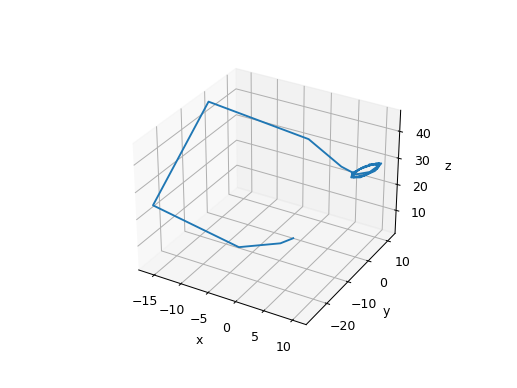

<IPython.core.display.Javascript object>


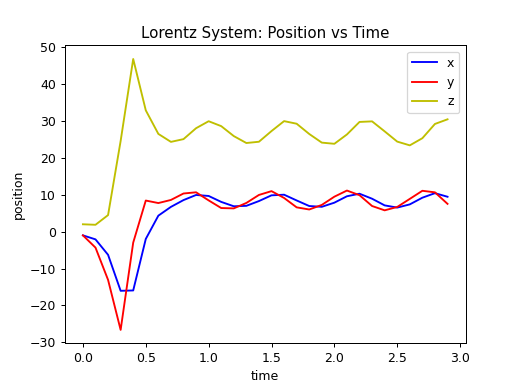

In [4]:
C1true = 10.0
C2true = 28
C3true = 8.0/3.0
x0=-1
y0=-1
z0=2
tend=3
dt=0.001 # for integration
tskip=100 # skip intiger number of times (simulate having less data available than required for numeric stability)
observe_t, ob_y, y0, tend = gen_training_data(C1=C1true, C2=C2true, C3=C3true, x0=x0, y0=y0, z0=z0, tend=tend, dt=dt, tskip=tskip)
plot_states(observe_t, ob_y)

# Declare Variable Coefficients

In [5]:

# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)


# Define the Governing PDE

In [6]:

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]



# Define ICs/BCs, geometry, and set the data

In [7]:
# define time domain
def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, tend)

# Initial conditions
ic1 = dde.IC(geom, lambda X: y0[0], boundary, component=0)
ic2 = dde.IC(geom, lambda X: y0[1], boundary, component=1)
ic3 = dde.IC(geom, lambda X: y0[2], boundary, component=2)

# Get extract the training data
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)


# Define Data Object

In [8]:
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=3000, # 400 in original code
    num_boundary=2,
    anchors=observe_t,
)

# plt.plot(observe_t, ob_y)
# plt.xlabel('Time')
# plt.legend(['x','y','z'])
# plt.title('Training data')
# plt.show()


/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  warnings.warn("The balance properties of Sobol' points require "


# Define FNN architecture and compile

In [9]:
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)


# Define Paths

In [19]:
save_dir = 'Lorentz_inverse_system'
model_name = 'model'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_Lorentz_inverse_system.dat'
train_fname = 'train_Lorentz_inverse_system.dat'
test_fname = 'test_Lorentz_inverse_system.dat'
var_fname = "variables_Lorentz_inverse_system.dat"

loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)
var_path = os.path.join(save_dir, var_fname)
# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

# Load Model

In [20]:
model.compile("adam", lr=1e-3)
model.restore(ckpt_path, verbose=1)

Compiling model...
'compile' took 0.299784 s

Restoring model from Lorentz_inverse_system/model-60000.ckpt ...

INFO:tensorflow:Restoring parameters from Lorentz_inverse_system/model-60000.ckpt


# Define callbacks for storing results

In [13]:
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=var_path
)

# Train the Network

In [14]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=60000, callbacks=[variable])

Compiling model...
'compile' took 0.286881 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.76e-01, 1.79e-01, 1.14e-01, 1.00e+00, 1.00e+00, 4.00e+00, 6.98e+01, 9.24e+01, 7.20e+02]    [2.76e-01, 1.79e-01, 1.14e-01, 1.00e+00, 1.00e+00, 4.00e+00, 6.98e+01, 9.24e+01, 7.20e+02]    []  
1000      [9.14e-01, 7.55e+00, 5.08e+01, 1.32e-01, 1.05e+01, 1.68e+01, 7.59e+01, 3.48e+01, 7.44e+01]    [9.14e-01, 7.55e+00, 5.08e+01, 1.32e-01, 1.05e+01, 1.68e+01, 7.59e+01, 3.48e+01, 7.44e+01]    []  
2000      [1.21e+00, 7.06e+00, 2.57e+01, 5.51e-01, 1.07e+01, 9.34e+00, 7.82e+01, 3.14e+01, 7.44e+01]    [1.21e+00, 7.06e+00, 2.57e+01, 5.51e-01, 1.07e+01, 9.34e+00, 7.82e+01, 3.14e+01, 7.44e+01]    []  
3000      [3.57e+00, 1.06e+01, 1.80e+01, 2.65e+00, 1.42e+01, 1.67e+00, 7.70e+01, 2.83e+01,

39000     [1.95e-02, 4.43e-02, 6.58e-02, 3.12e-04, 2.00e-04, 1.72e-05, 9.08e-03, 1.64e-02, 2.52e-02]    [1.95e-02, 4.43e-02, 6.58e-02, 3.12e-04, 2.00e-04, 1.72e-05, 9.08e-03, 1.64e-02, 2.52e-02]    []  
40000     [2.13e-02, 3.21e-02, 7.56e-02, 2.61e-04, 1.30e-04, 7.09e-05, 6.45e-03, 1.16e-02, 1.80e-02]    [2.13e-02, 3.21e-02, 7.56e-02, 2.61e-04, 1.30e-04, 7.09e-05, 6.45e-03, 1.16e-02, 1.80e-02]    []  
41000     [1.91e-02, 2.64e-02, 5.26e-02, 6.50e-05, 1.21e-04, 2.78e-04, 4.42e-03, 7.79e-03, 1.18e-02]    [1.91e-02, 2.64e-02, 5.26e-02, 6.50e-05, 1.21e-04, 2.78e-04, 4.42e-03, 7.79e-03, 1.18e-02]    []  
42000     [1.77e-02, 2.44e-02, 3.98e-02, 1.74e-04, 9.89e-05, 4.55e-05, 3.03e-03, 5.91e-03, 8.64e-03]    [1.77e-02, 2.44e-02, 3.98e-02, 1.74e-04, 9.89e-05, 4.55e-05, 3.03e-03, 5.91e-03, 8.64e-03]    []  
43000     [1.64e-02, 3.22e-02, 4.35e-02, 9.96e-05, 5.68e-05, 2.59e-05, 2.49e-03, 4.49e-03, 6.59e-03]    [1.64e-02, 3.22e-02, 4.35e-02, 9.96e-05, 5.68e-05, 2.59e-05, 2.49e-03, 4.49e-03, 6.5

# Save Model

In [16]:
model.save(model_path)

INFO:tensorflow:Lorentz_inverse_system/model-60000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'Lorentz_inverse_system/model-60000.ckpt'

# Plot Training Performance

Saving loss history to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Lorentz_inverse_system/loss_Lorentz_inverse_system.dat ...
Saving training data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Lorentz_inverse_system/train_Lorentz_inverse_system.dat ...
Saving test data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Lorentz_inverse_system/test_Lorentz_inverse_system.dat ...


<IPython.core.display.Javascript object>


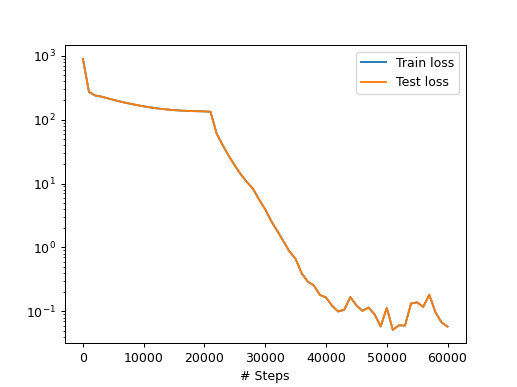

<IPython.core.display.Javascript object>


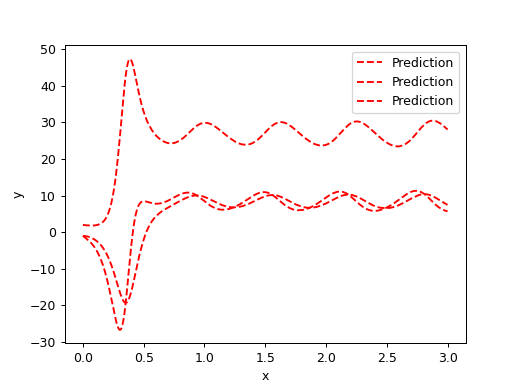

In [17]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)


# Plot Results

<IPython.core.display.Javascript object>


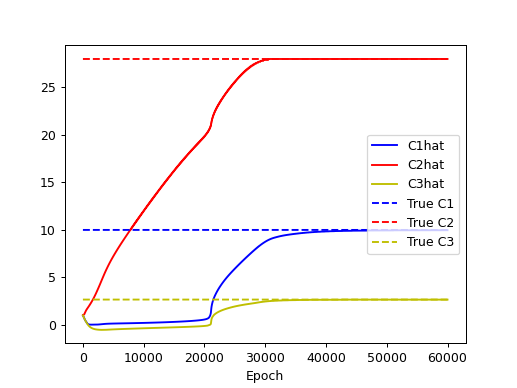

In [21]:
# reopen saved data using callbacks in fnamevar 
lines = open(var_path, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.figure()
plt.plot(range(l),Chat[:,0],'b-')
plt.plot(range(l),Chat[:,1],'r-')
plt.plot(range(l),Chat[:,2],'y-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'b--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'r--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'y--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

In [22]:
pred_y = model.predict(observe_t)
t = observe_t[:, 0]

x_pred = pred_y[:,0]
y_pred = pred_y[:,1]
z_pred = pred_y[:,2]
x_true = ob_y[:,0]
y_true = ob_y[:,1]
z_true = ob_y[:,2]

<IPython.core.display.Javascript object>


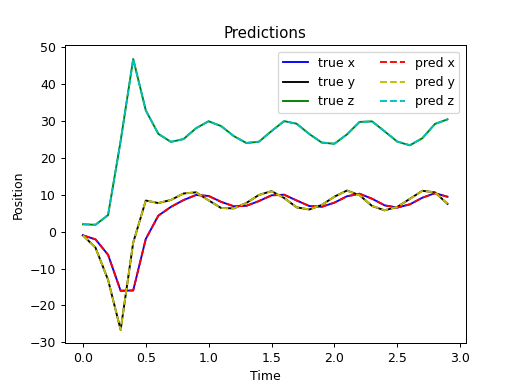

In [23]:

plt.figure()

plt.plot(t, x_true, 'b-', label='true x')
plt.plot(t, y_true, 'k-', label='true y')
plt.plot(t, z_true, 'g-', label='true z')

plt.plot(t, x_pred, 'r--', label='pred x')
plt.plot(t, y_pred, 'y--', label='pred y')
plt.plot(t, z_pred, 'c--', label='pred z')



# plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(ncol=2)
plt.title('Predictions')
plt.show()